# Learning Goals
This tutorial is a continuation of the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook.  In this tutorial we will learn how to:
- Retrieve TESS mission Co-trending Basis Vectors and interpolate them for the FFI images
- Construct a TESS data model based on data from other sources
- Create a Design Matrix for de-trending TESS data from a variety of noise models
- De-trend the TESS light-curve 
- Add a model component to our de-trended lightcurve

# Introduction
From the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook we found that our TESS background subtracted lightcurve had some long-timescale behavior that was similar to that seen from the ground.  
![TESS](TESS-ASAS.png)
In this notebook we will apply a series of more complicated lightcurve de-trending corrections, while also calculating a long-timescale flux model from the ground-based ASAS-SN data that we will use to both de-trend the observed TESS data and then re-apply it to recover the long-timescale variability.  


## First, let us recover our data from the previous notebook

In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import MPLSTYLE

import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

import pickle

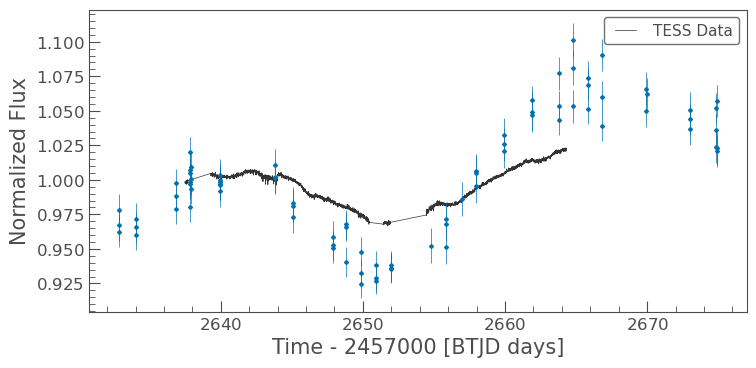

In [2]:
# Read our lc and tpf from the previous notebook
lc=lk.read('NGC4151_lc_bkgsub.fits',quality_bitmask='none')
tpf=lk.read('NGC4151_tpf_bkgsub.fits',quality_bitmask='none')

# Recover our target mask and background mask from the previous notebook
target_mask, bigger_mask = pickle.load(open( "masks.p", "rb" ))

#Re-read the ASAS-SN ground-based g-band data
asas=pd.read_csv('ngc4151_asas.csv')
jdcut=(asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
asas=asas[jdcut]

with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')

# From our previous notebook:
## We're assuming that there are long-baseline (comparable to the sector length) trends in the TESS data that are both real and similar in behavior to that observed by the ground-based ASAS-SN team
As a first pass at the reduction -  lets do a detrending reduction incorporating a spline that has a similar number of knots to the features observed in the ASAS-SN data

**This assumes the least amount of information:**  That there are long baseline features, and their approximate feature timescales (~days here)

##### First, we will use lightkurve to get the missions co-trending basis vectors for the target.  We will interpolate them to the FFI cadence, since they were calculated on the more rapidly observed TESS TICs.  

For a detailed discussion of de-trending vectors and the design matrix, see [Rebekah Hounsell's notebook on TESS-JWST and WASP-43b]

In [3]:
# Obtain the CBVs from the mission
# interpolate from 2min cbvs
ncbvs = 3

cbvc = lk.CBVCorrector(lc, interpolate_cbvs=True)
multiscale1 = cbvc.cbvs[1].interpolate(lc).to_pandas()
multiscale2 = cbvc.cbvs[2].interpolate(lc).to_pandas()
cbvs = np.hstack([np.asarray(multiscale2[multiscale2.columns[2:2+ncbvs]])])

##### Next, we will create a new design matrix collection,  using a series of design matrices, each. of which correct based on a different systematic measurement
These are:
-  A design matrix based of the co-trending vectors from. TESS TIC's interpolated. to the FFIs
- A design matrix based on the first two components of the  background's PCA decomposition
- A design matrix, based on the centroids movement
- A spline, created with a number of knots similar. to the known features from. the ASAS-SN data


Again, for a detailed discussion of de-trending vectors and the design matrix, see [Rebekah Hounsell's notebook on TESS-JWST and WASP-43b]

In [4]:
#Estimate the pointing centroids from the TPF
row,col = tpf.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)

# Design matrix with Cotrending Basis Vectors
dm_cbv = lk.DesignMatrix(cbvs[k], name='cbvs')#.split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

# Design matrix with PCA of the pixels outside the aperture
dm_pca = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design Matrix based off Centroid Movement
dm_centroid = lk.DesignMatrix(np.nan_to_num(np.vstack([row.value, col.value,
                                               row.value*col.value]).T)[k],
                      name='centroids').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

# Design Matrix based off spline
knot_list_tess=np.linspace(np.min(lc.time.value+0.000001),
                           np.max(lc.time.value-0.000001),7).tolist()

dm_spline = lk.designmatrix.create_spline_matrix(lc.time.value,knots=knot_list_tess)

# Combined Design Matrix
dm_spline_comb = lk.DesignMatrixCollection([dm_pca, 
                                            dm_cbv,
                                            #dm_centroid,
                                            dm_spline.append_constant()])

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

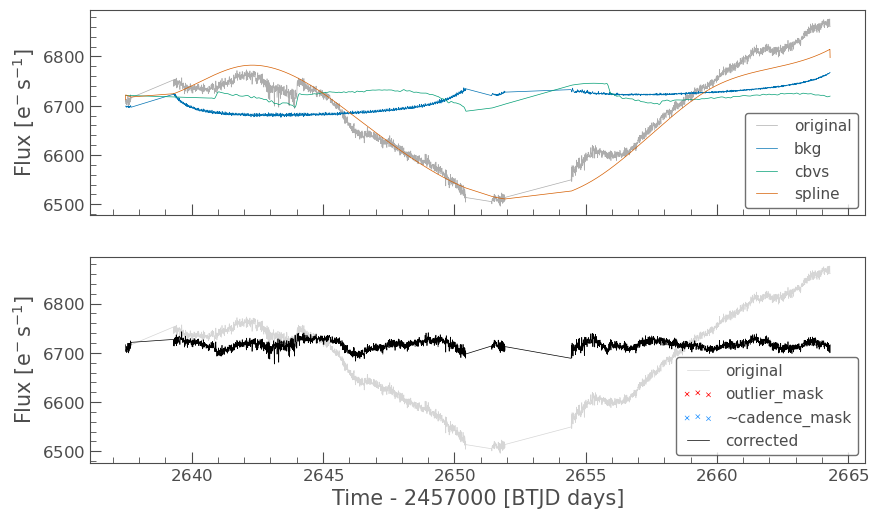

In [5]:
r_spline = lk.RegressionCorrector(lc)
r_spline_norm = lk.RegressionCorrector(lc.normalize())

r_spline.correct(dm_spline_comb)
r_spline_norm.correct(dm_spline_comb)

r_spline.diagnose()

## **Now, add our best-fit spline back into the calibrated data**
Here we're taking the 'corrected lightcurve' which is very flat as we removed lots of. systematics, and are multiplying it by the 'diagnostic lightcurve' for the spline, which is the normalized best-fit spline component that we believe represents our long-baseline data and we want re-introduced to our data.  

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

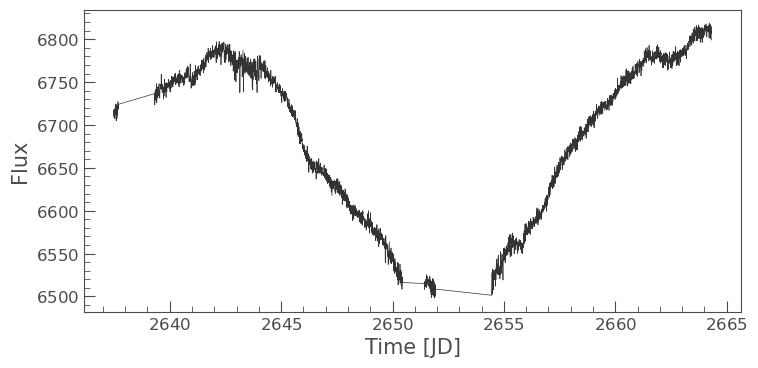

In [6]:
splnorm=r_spline_norm.diagnostic_lightcurves['spline']

lc_SplineCorrected=lk.LightCurve(time=r_spline.corrected_lc.time.value,
                                 flux=r_spline.corrected_lc.flux.value*splnorm.flux.value,
                                 flux_err=r_spline.corrected_lc.flux_err.value)
lc_SplineCorrected.plot()

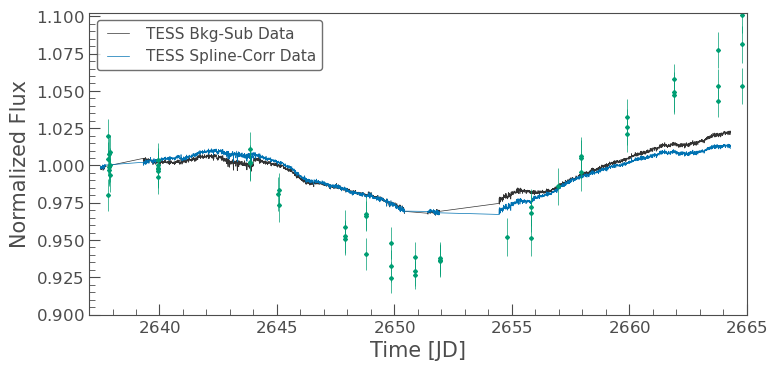

In [7]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Bkg-Sub Data')
    lc_SplineCorrected.plot(ax=ax,normalize=True, label='TESS Spline-Corr Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.set_xlim(2637,2665)
    ax.set_ylim(0.9,1.1025)

### **This is now a calibrated, detrended lightcurve with all of the standard mission systematics removed, and our long-term baseline re-introduced.   This long-term baseline may. or *may not* have. additional systematics, as we only specified timescales in the spline rather than a functional form**

The TESS mission has its own systematics that can occur on these timescales that may distort the inherant long-term trends of our target.  To go past this, we will essentially need a model of what our long-timescale lightcurve looks like.  

To do this, **we will assume** that it has the same shape as the ASAS-SN normalized light-curve with a multiplicative factor. **This may or may not be accurate, and we are doing this to demonstrate technique as much as a final result**

To create this model-dependant lightcurve we will need a smooth interpolation of the ASAS-SN data with a normalized value at each point.  More complicated models are left to the user and their specific science needs.  

For our interpolation needs, we will use a gaussian process regressor with a RBF kernel and a white noise kernel (to capture the error behavior) of our points.  

In [8]:
# We want to do our regression with the asas-sn data, but predict on the tess epochs
def gpinterp(btjd,flux,tessjd):
    time=np.array(btjd).reshape(-1,1)
    val=np.array(flux)
    kernel =1.0*RBF(length_scale=2, length_scale_bounds=(0.5,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=tessjd.reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

Next, we fit this gaussian process regressor to the ASAS-SN g-band data, while interpolatingits values using the TESS lightcurve. 

In [9]:
# We're padding this a bit to avoid edge effects
sector_mask = (asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
gp_t, \
gp_f, \
gp_sig = gpinterp(asas.HJD-2457000, asas.flux/np.median(asas.flux),lc.time.value)

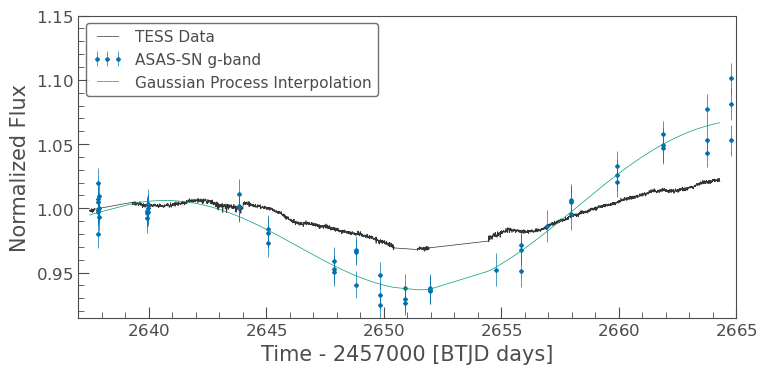

In [10]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f,label='Gaussian Process Interpolation')
    ax.set_ylim(0.915,1.15)
    ax.set_xlim(2637,2665)
    ax.legend(loc=2)

Noteably here, we will add a design matrix, dm_gp below, that is our normalized gaussian process interpolated lightcurve and replaces our spline design matrix

In [11]:
# Design matrix with a gp model
dm_gp = lk.DesignMatrix(gp_f[k], name='gp_model')

# Combined Design Matrix

# Combined Design Matrix
dm_gp_comb = lk.DesignMatrixCollection([dm_pca, 
                                        dm_cbv.append_constant(),
                                        dm_centroid,
                                        dm_gp])

array([<AxesSubplot:ylabel='Flux'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>],
      dtype=object)

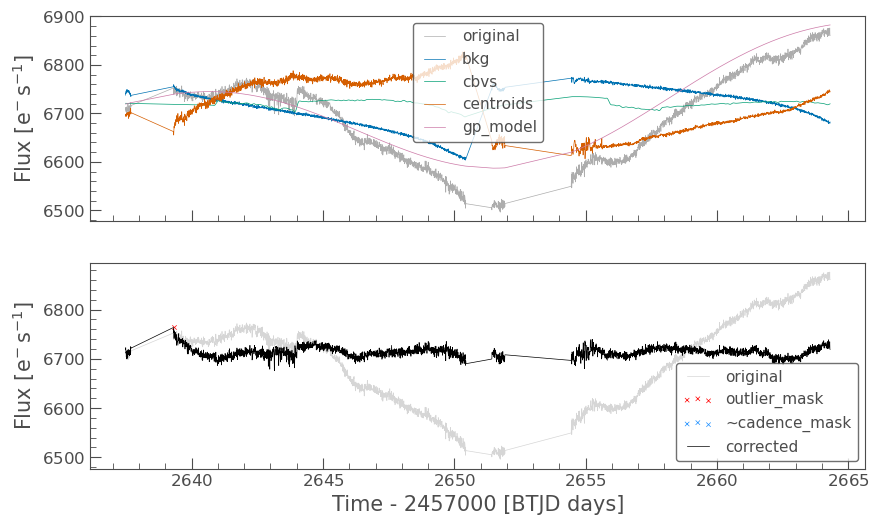

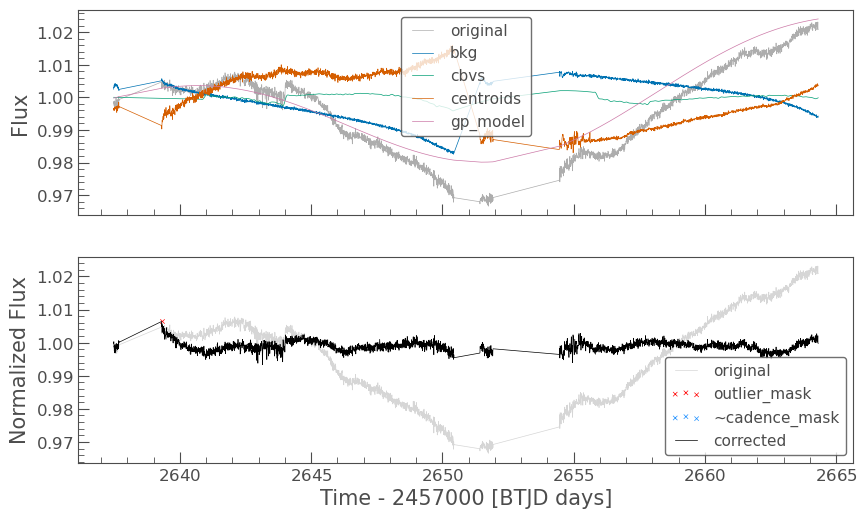

In [12]:
# Correct the light curve using combined design matrix
r_gp_norm = lk.RegressionCorrector(lc[k].normalize())
r_gp = lk.RegressionCorrector(lc[k])

r_gp.correct(dm_gp_comb)
r_gp_norm.correct(dm_gp_comb)

r_gp.diagnose()
r_gp_norm.diagnose()

In [13]:
print(dm_gp_comb)
r_gp_norm.coefficients

DesignMatrixCollection:
	bkg DesignMatrix (3128, 2)
	cbvs DesignMatrix (3128, 4)
	centroids DesignMatrix (3128, 9)
	gp_model DesignMatrix (3128, 1)



array([ 8.93059788e-02,  3.19984800e-01,  1.24401073e-01, -1.11964990e-01,
        2.38765030e-02,  8.80446793e+02, -4.97887136e-01, -7.06473035e-01,
        3.96310295e-04, -3.88745275e-01, -8.76276842e-01,  4.57780569e-04,
       -5.58704113e-01, -7.66634718e-01,  4.99205518e-04,  3.38264720e-01])

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

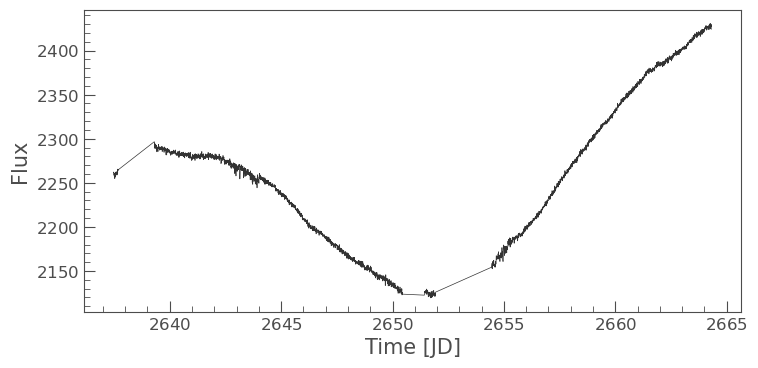

In [14]:
gpnorm=gp_f*r_gp_norm.coefficients[15]


lc_GPCorrected=lk.LightCurve(time=r_gp.corrected_lc.time.value,
                                 flux=r_gp.corrected_lc.flux.value*gpnorm,
                                 flux_err=r_gp.corrected_lc.flux_err.value)
lc_GPCorrected.plot()

### Our TESS light-curve now has an overall trend that is very similar to our initial model

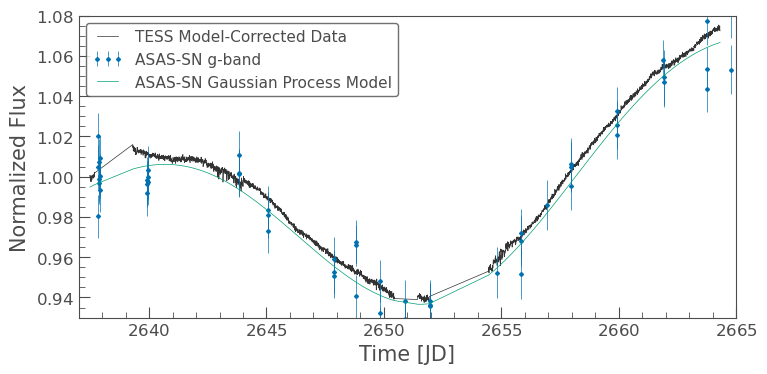

In [19]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc_GPCorrected.plot(ax=ax,normalize=True,label='TESS Model-Corrected Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
    ax.set_ylim(0.93,1.08)
    ax.set_xlim(2637,2665)
    ax.legend()

# We can also compare these two different reductions against each-other and the less calibrated background data

NameError: name 'lc3' is not defined

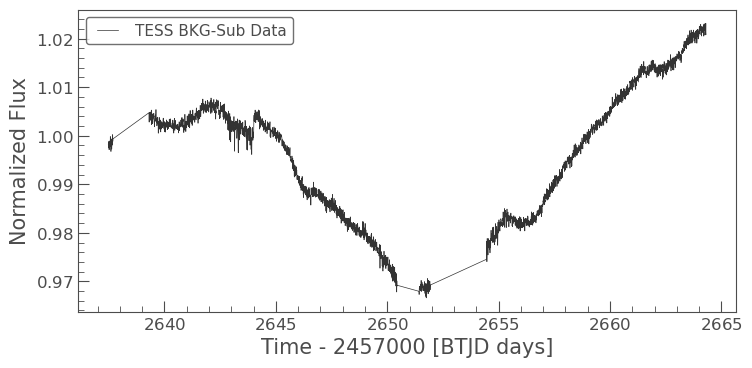

In [20]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS BKG-Sub Data')
    lc3.plot(ax=ax,normalize=True, label='TESS GP-Model+De-Trending')
    lc_SplineCorrected.plot(ax=ax,normalize=True, label='TESS Spline+De-Trending')

    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
   
    ax.set_ylim(0.93,1.08)
    ax.set_xlim(2637,2665)
    ax.legend()

In [ ]:
pd=lc.to_periodogram(method='lombscargle')
pd_spl=lc_SplineCorrected.to_periodogram(method='lombscargle')
pd_gp=lc_GPCorrected.to_periodogram(method='lombscargle')

pd=pd.bin()
pd_spl=pd_spl.bin()
pd_gp=pd_gp.bin()

with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    pd.plot(ax=ax,scale='log',label='Background Subtracted')
    pd_spl.plot(ax=ax,scale='log',label='Spline+De-Trending')
    pd_gp.plot(ax=ax,scale='log',label='GP+De-Trending')
    